In [105]:
import os
import math
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

In [50]:
import torch
import torch.nn as nn
from torch.nn import functional as f

from torch.utils.data import DataLoader

from torchvision import transforms

from utils import get_device_name, get_model

from lib.datasets import ShopeeDataset
from lib.utils import pdist_l2

In [148]:
def draw_duplicates(indices: list, data: pd.DataFrame, path: str):
    n = len(indices)
    
    columns = 5
    rows = math.ceil(n / columns)
    
    fig = plt.figure(figsize=(4 * columns, 4 * rows))

    for i, indx in enumerate(indices):
        ax = fig.add_subplot(rows, columns, i+1)
        ax.axis('off')
        
        item_img_path = os.path.join(path, 'train_images', data.image[indx])
        item_title = data.title[indx]
        
        inp = plt.imread(item_img_path)
        
        plt.imshow(inp)


In [52]:
df = pd.read_csv('/data/shopee-product-matching/new_val.csv')

In [53]:
df.shape

(2087, 7)

Объединение всех индексов по своим `label_group`

In [54]:
label2index = df.reset_index().groupby('label_group').index.agg('unique').to_dict()
df['target_indexes'] = df.label_group.map(label2index)

Предсказание модели

In [14]:
device, multi_gpu = get_device_name(cuda=True)

model = get_model(model_name="resnet50", pretrained=True, finetune=False, embedding_size=224)

if multi_gpu:
    model = nn.DataParallel(model)
model = model.to(device)

model_path = '/data/models/semi_hard_new_triplet_margin_loss_1'

model2epoch = {model: int(model.split('_')[-1].split('.')[0]) for model in os.listdir(model_path)}
last_model = max(model2epoch, key=lambda k: model2epoch[k])

print(f'Load model: {os.path.join(model_path, last_model)}')

checkpoint = torch.load(os.path.join(model_path, last_model))
# model = checkpoint['model']

if multi_gpu:
    model.module.load_state_dict(checkpoint['state_dict'])
    # model = model.module

else:
    model.load_state_dict(checkpoint['state_dict'])

Load model: /data/models/semi_hard_new_triplet_margin_loss_1/model_epoch_199.pth


In [16]:
dataset = ShopeeDataset(
    dataset_path='/data/shopee-product-matching/new_val.csv',
    images_dir='/data/shopee-product-matching/train_images',
    transform=transforms.Compose(
        [
            transforms.Resize((220, 220)),
            transforms.ToTensor(),
            transforms.Normalize(
                (0.485, 0.456, 0.406),
                (0.229, 0.224, 0.225)
            ),
        ]
    )
)

dataloader = DataLoader(dataset, batch_size=32, shuffle=False)

In [17]:
embeddings = []
targets = []

with torch.no_grad():
    for data, labels in tqdm(dataloader):
        data = data.to(device)

        outputs = model(data).cpu()
        target = labels
        
        outputs = f.normalize(outputs, dim=-1, p=2)

        embeddings.append(outputs)
        targets.append(target)

embeddings = torch.cat(embeddings, dim=0)
targets = torch.cat(targets, dim=0)

100%|██████████| 66/66 [00:24<00:00,  2.67it/s]


In [27]:
dist_matrix = pdist_l2(embeddings).cpu().detach().numpy()

In [29]:
dist_matrix.shape

(2087, 2087)

# Таргеты

In [70]:
df.target_indexes.head(10)

0    [0, 35, 604, 670, 675, 685, 1154, 1469, 1510, ...
1                      [1, 587, 614, 1049, 1698, 1868]
2                                 [2, 273, 1216, 1535]
3                                    [3, 4, 788, 1279]
4                                    [3, 4, 788, 1279]
5    [5, 61, 129, 161, 742, 769, 819, 883, 1139, 12...
6    [6, 68, 268, 349, 488, 631, 873, 905, 1047, 12...
7               [7, 82, 83, 861, 862, 940, 1688, 2069]
8                       [8, 548, 585, 877, 1287, 1931]
9                       [9, 359, 931, 998, 1629, 1929]
Name: target_indexes, dtype: object

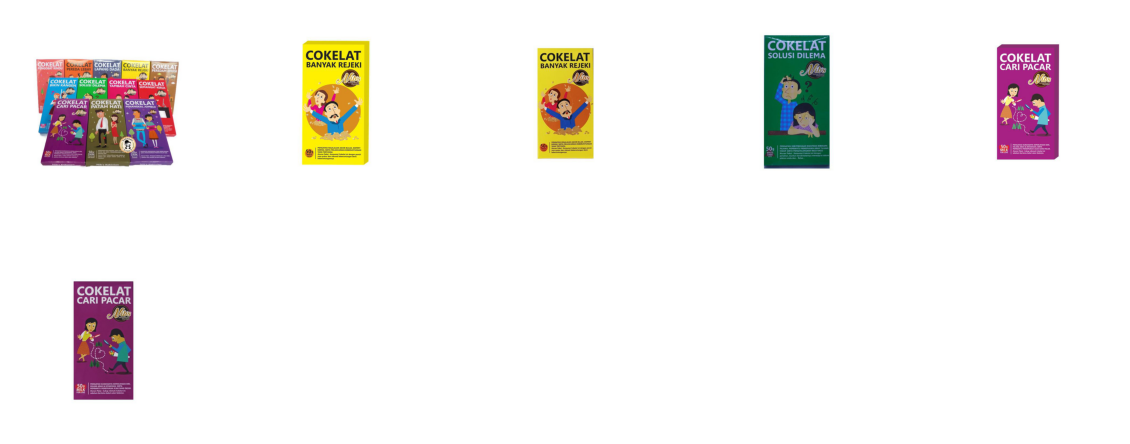

In [149]:
draw_duplicates([1, 587, 614, 1049, 1698, 1868], data=df, path='/data/shopee-product-matching')

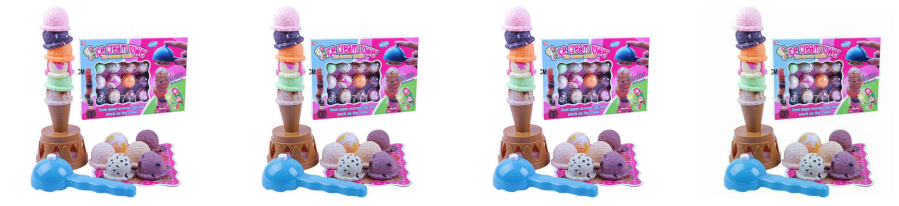

In [150]:
draw_duplicates([3, 4, 788, 1279], data=df, path='/data/shopee-product-matching')

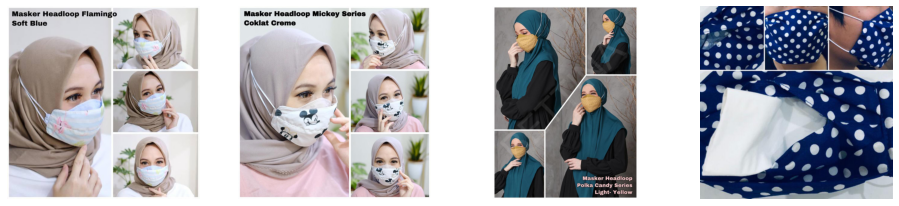

In [151]:
draw_duplicates([2, 273, 1216, 1535], data=df, path='/data/shopee-product-matching')

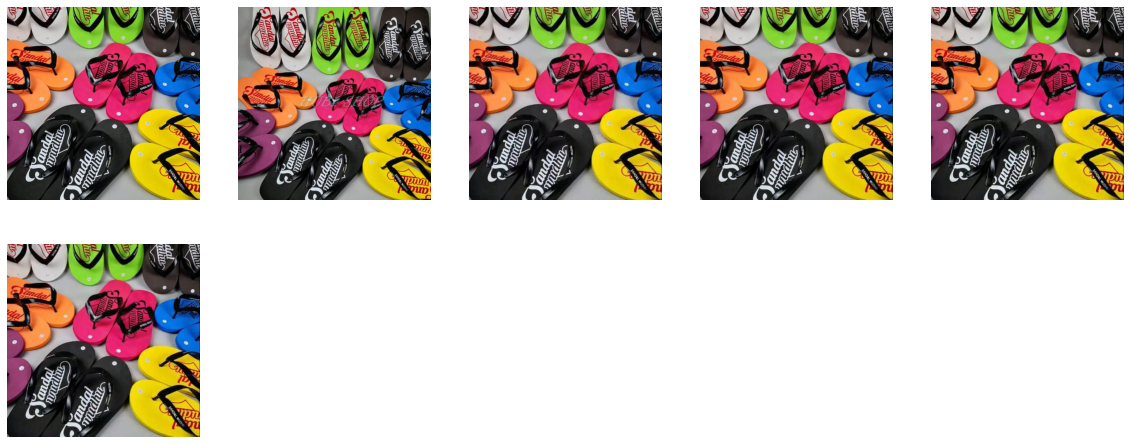

In [152]:
draw_duplicates([8, 548, 585, 877, 1287, 1931], data=df, path='/data/shopee-product-matching')

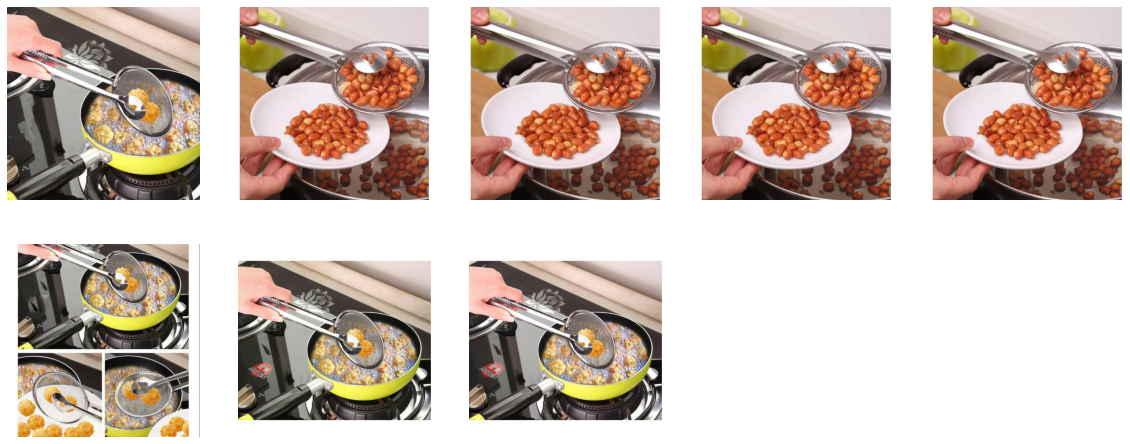

In [153]:
draw_duplicates([7, 82, 83, 861, 862, 940, 1688, 2069], data=df, path='/data/shopee-product-matching')

# Моя модель

In [30]:
def get_matches(indice, dist_matrix, thr):
    return np.where(dist_matrix[indice] < thr)[0]

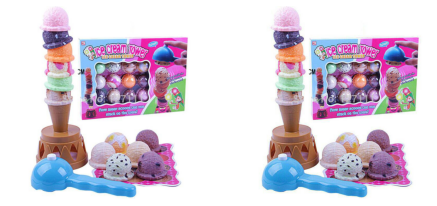

In [168]:
draw_duplicates(get_matches(3, dist_matrix, thr=0.5), data=df, path='/data/shopee-product-matching')

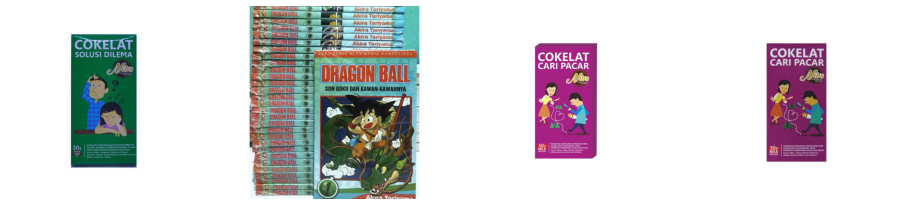

In [169]:
draw_duplicates(get_matches(1698, dist_matrix, thr=0.5), data=df, path='/data/shopee-product-matching')

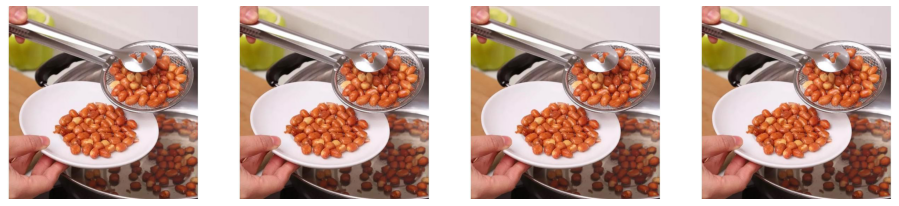

In [170]:
draw_duplicates(get_matches(82, dist_matrix, thr=0.5), data=df, path='/data/shopee-product-matching')

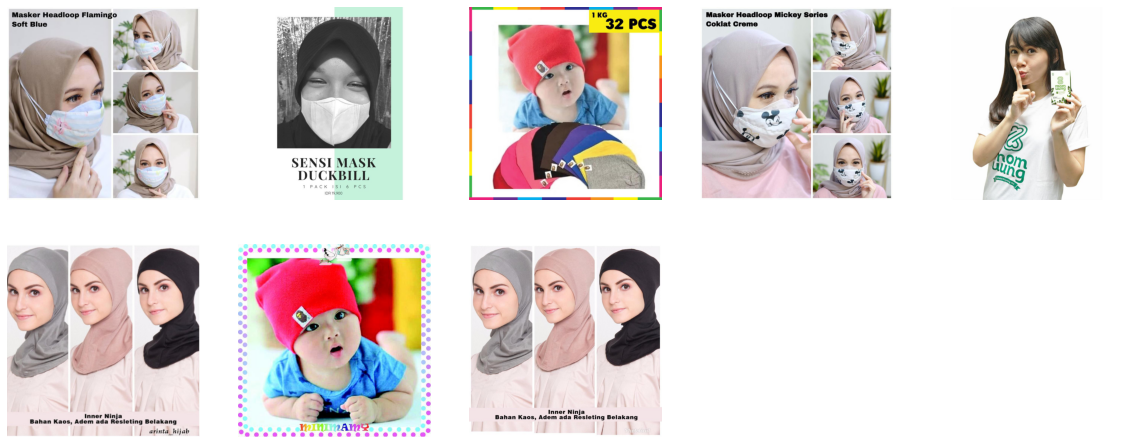

In [171]:
draw_duplicates(get_matches(273, dist_matrix, thr=0.5), data=df, path='/data/shopee-product-matching')

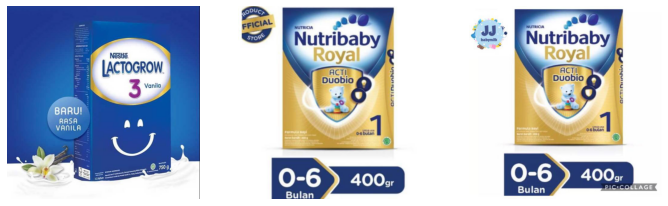

In [158]:
draw_duplicates(get_matches(734, dist_matrix, thr=0.5), data=df, path='/data/shopee-product-matching')

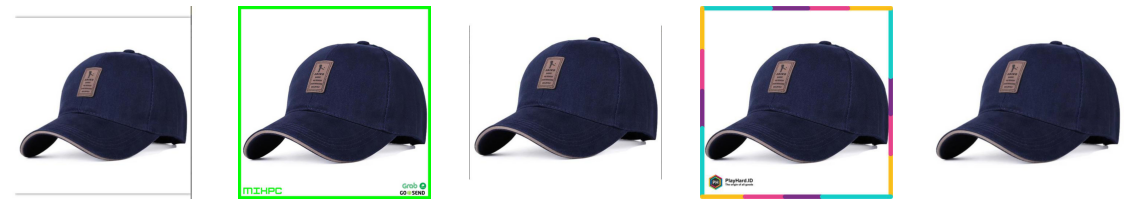

In [159]:
draw_duplicates(get_matches(127, dist_matrix, thr=0.5), data=df, path='/data/shopee-product-matching')

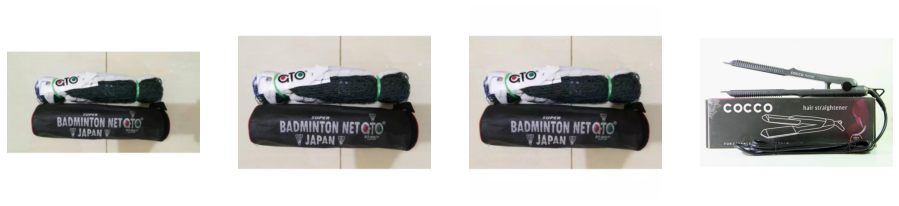

In [160]:
draw_duplicates(get_matches(74, dist_matrix, thr=0.5), data=df, path='/data/shopee-product-matching')

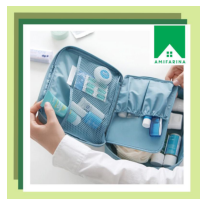

In [161]:
draw_duplicates(get_matches(1293, dist_matrix, thr=0.5), data=df, path='/data/shopee-product-matching')

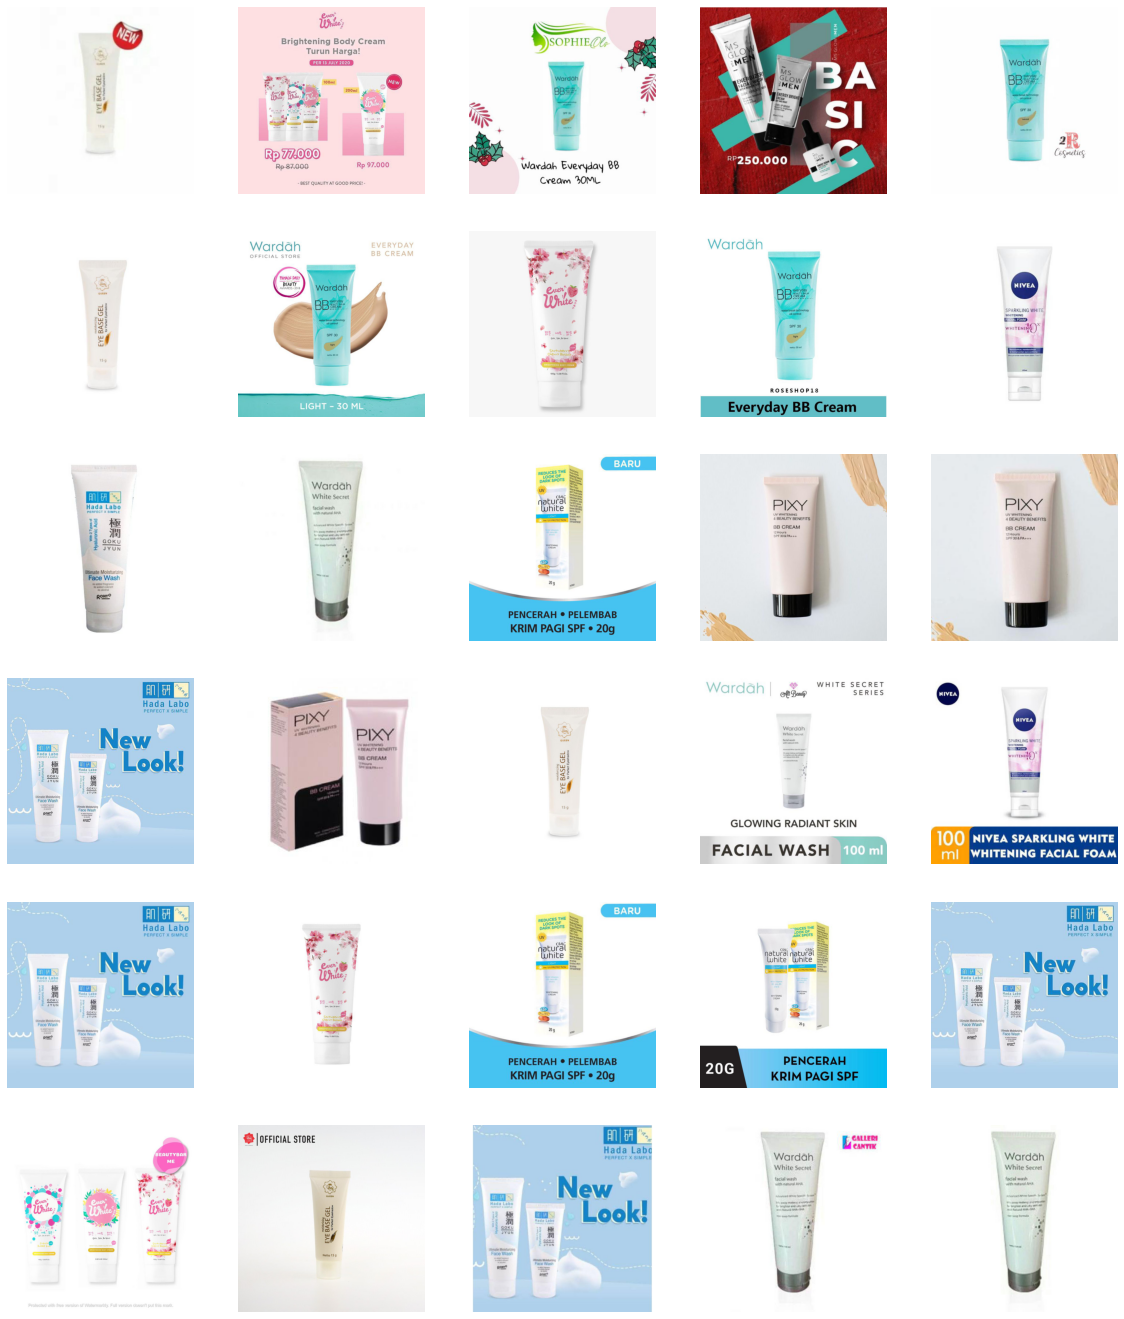

In [162]:
draw_duplicates(get_matches(1286, dist_matrix, thr=0.5), data=df, path='/data/shopee-product-matching')